# Data collection and preprocessing 

You will find in this notebook the code to be executed to collect data as reported in section II of the report.

In [1]:
import library_data as data 
import library_plot as plot
import library_stats as stats
import library_stylized_facts as sf

from datetime import datetime
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

## A. Historical cryptocurrency

You can find all the necessary imports in the notebook `Results.ipynb`.

In [2]:
# ----- INTRADAY DATA ----
path_btc = "data/raw/intraday_historical/BTC_intraday.csv"

path_ltc_mob = "data/raw/binanceus/binanceus_LTCUSD/mob/"
path_ada_mob = "data/raw/binanceus/binanceus_ADAUSD/mob/"
path_eth_mob = "data/raw/bitstamp_ETHUSD/mob/"

path_ltc = "data/raw/intraday_historical/LTC_intraday"
path_ada = "data/raw/intraday_historical/ADA_intraday"
path_eth = "data/raw/intraday_historical/ETH_intraday"

#Retrieve close price on 1-min frequency from mob data
#data.close_price_all(path_ltc_mob, "LTC")
#data.close_price_all(path_ada_mob, "ADA")
#data.close_price_all(path_eth_mob, "ETH")

#Create final file
data.merge_historical_data()

# Load data
df_btc = data.get_btc_intraday(path_btc)
df_ada = pd.read_parquet(path_ada)
df_ltc = pd.read_parquet(path_ltc)
df_eth = pd.read_parquet(path_eth)

# -------- DAILY DATA -------
start = "2018-12-31"
btc_daily = data.get_daily("BTC-USD", start)

There are no NaN values in the dataframe


## B. Google Trends

In [5]:
#Time period of interest for collecting data
start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31)

#Collect data for all keywords of interest (demo version with daily data)
#for kw_index in range(4) :
    #data.main_google_trends_daily(kw_index)

#Merge and normalize all downloaded files (hourly data)
for kw_index in range(4) :
    data.main_google_trends_hourly(kw_index)

#Merge all results
#data.merge_google_trends()

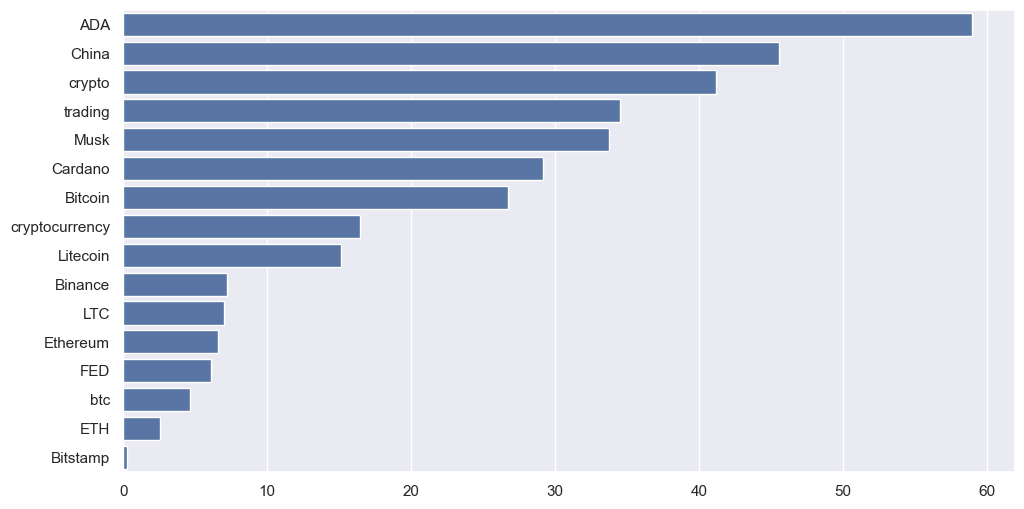

In [6]:
#Retrieve file with all keywords
df = pd.read_parquet('data/raw/google_trends/hourly/merged/all')

#Plot evolution of keywords (takes some time)
#plot.keywords_evolution(df, 4, 4)

#Ranking of keywords by maximum index
plot.rank_keywords_index(df)

In [8]:
# Final dataframe with Google Trends data and historical data 

# ----- Load data -----
cryptos = ['btc', 'ltc', 'ada', 'eth']

kw_df = pd.read_parquet('data/raw/google_trends/hourly/merged/all')

path_btc = "data/raw/intraday_historical/BTC_intraday.csv"
path_ltc = "data/raw/intraday_historical/LTC_intraday"
path_ada = "data/raw/intraday_historical/ADA_intraday"
path_eth = "data/raw/intraday_historical/ETH_intraday"

df_btc = data.get_btc_intraday(path_btc)[["Close"]]
df_ada = pd.read_parquet(path_ada)
df_ltc = pd.read_parquet(path_ltc)
df_eth = pd.read_parquet(path_eth)

start_date = datetime(2021, 1, 1)
end_date = datetime(2021, 12, 31, 23, 59)

# ----- Select right timeframe ----- 
for crypto in cryptos : 
    locals()[f'df_{crypto}'] = data.filter_timeframes(start_date, end_date, locals()[f'df_{crypto}'])

# ----- Compute logreturns ----
for crypto in cryptos:
    locals()[f'df_{crypto}'] = sf.logreturns(locals()[f'df_{crypto}'], "Close")[['Logrets']]

# ----- Transform intraday data to hourly data ----
for crypto in cryptos:
    locals()[f'df_{crypto}'] = data.minutes2hours(locals()[f'df_{crypto}'])

# ----- Preprocessing keywords data ----- 
kw_df = data.proprocessing_keywords(kw_df, start_date, end_date)

# ---- Merge all data into one dataframe ---- 
data.data_transfer_entropy(df_btc, df_ada, df_eth, df_ltc, kw_df)

There are no NaN values in the dataframe
